## Imports

In [1]:
import csv
import matplotlib.pyplot as plt

import numpy as np
import trompy as tp
from datetime import datetime
import pandas as pd

%matplotlib inline


from scipy import stats

In [2]:
def extract_event_fn(filename): 
    '''
    function to extract framenumber of events (licks and pump_on) in framenumber
    
    args
    filename - string 
    
    returns 
    licks_fn - lits of integers
        framenumber of licks
    pump_on_fn - list of integers 
        framenumber when pump turns on
    
    '''
    df= pd.read_csv(filename)
    
    #Extracts pump on framenumber
    pump_fn = list(df[df['Item1'] == 'pump_on']['Item2.Item2'])
    
    
    #Extracts licks framenumber
    licks_fn = list (df[df['Item1']== 'Lick']['Item2.Item2'])

      
    return pump_fn, licks_fn
        


In [3]:
def get_hit_miss_trial (pump_fn, licks_fn): 
    '''
    function to get hit and miss trials
    
    arg 
    pump_fn - list of integers
        framenumber for when the pump turns on 
    licks_fn - list of integers
        framenumber for all licks
    triallenght - int float (optional, default set to 100 frames (10sec))
    
    returns 
    hit_trial - list of int 
        pump on frame number in hit trials (lick > 0)
    miss_trial - list of int 
        pump on frame number in missed trials (lick = 0)
    
    '''
    hit_trial=[]
    miss_trial=[]
    for p in pump_fn: 
        temp=[]
        for lick in licks_fn: 
            if lick > p and lick < p + 100: 
                temp.append(lick)
            
        if len(temp)> 0:
            hit_trial.append(p)
        if len(temp) == 0: 
            miss_trial.append(p)
    return hit_trial, miss_trial

In [4]:
def get_licks_trial (pump_fn, licks_fn, triallength=100):
    '''
    function to get licks within one trial 
    licks aligned to pump on (pump_fn)
    
    arg 
    pump_fn - list of integers
        framenumber for when the pump turns on 
    licks_fn - list of integers
        framenumber for all licks
    triallenght - int float (optional, default set to 100 frames (10sec))
    
    returns 
    licks_trial - list of list of integers
        list of all licks in all trials aligned to pump on (in frames)
    licks_all_trial - list of integers
        number of licks of each trial 
    licks_hit_trial - list of integers 
        number of licks per trial for hit trials 
    latency - list of integers
        latency to first lick after pump on (in frames)
        
    
    '''

    # All licks aligned to pump on 
    licks_trial=[]
    for p in pump_fn:
        temp=[]
        for lick in licks_fn: 
            if lick > p and lick < p + 100:
                temp.append(lick - p)
        licks_trial.append(temp)
        
        
    #licks per trial (all and hit trials) aligned to pump on 
    licks_all_trial=[]
    licks_hit_trial=[]
    for trial in licks_trial: 
        licks_all_trial.append(len(trial))
        if len(trial) > 0: 
            licks_hit_trial.append(len(trial))
            
            
    #Latency to first lick after pump on
    temp_latency=[]
    for trial in licks_trial:
        if len(trial) > 0: 
            temp_latency.append(trial[:1])
    
    latency=[trial for sublist in temp_latency for trial in sublist] #List comprehension to convert list of lists to flat list     
            
        
    return licks_trial, licks_all_trial, licks_hit_trial, latency

## Metafile reader

In [5]:
rows,header=tp.metafilereader('C:\\Users\\mko102\\UiT Office 365\\O365-Pipette 2 - Dokumenter\\People\\Mette\\GitHub\\2P\\Metafile_VGP2.2.xls',sheetname='Behavior')
folder= 'C:\\Users\\mko102\\UiT Office 365\\O365-Pipette 2 - Dokumenter\\People\\Mette\\GitHub\\2P\\VGP2\\Bonsai\\'

File is excel file. Making csv metafile first


## Dictionary

In [6]:
all_data={}

for row in rows: 
    try:
        key=row[0]+ '_' + row[4]
    
        pump_fn, licks_fn = extract_event_fn(folder+row[1])
        hit_trial, miss_trial = get_hit_miss_trial(pump_fn, licks_fn)
        licks_trial, licks_all_trial, licks_hit_trial, latency = get_licks_trial(pump_fn, licks_fn)
        
    
        all_data[key]={}

        all_data[key]['mouse']=row[0]
        all_data[key]['diet']=row[7]
        all_data[key]['solution']=row[8]
    
#         all_data[key]['file']=row[1]
#         all_data[key]['licks_fn']= licks_fn
#         all_data[key]['pump_fn']= pump_fn
#         all_data[key]['licks trial']= licks_trial
        all_data[key]['number of trials']=len(pump_fn)
        all_data[key]['total licks']=len(licks_fn)
        all_data[key]['hit trial'] = len(hit_trial)
        all_data[key]['miss trials']= len(miss_trial)
        all_data[key]['licks per trial']= np.mean(licks_all_trial)
        all_data[key]['licks hit trial']= np.mean(licks_hit_trial)
        all_data[key]['latency']= np.mean(latency)
    
        
    except FileNotFoundError: 
        print('Cannot find file for', key)

# Making groups and figures

In [17]:
mice=[]

for key in all_data.keys(): 
    d=all_data[key]
    mouseid=d['mouse']
    if mouseid not in mice: mice.append(mouseid)
        
mice

['VGP118',
 'VGP202',
 'VGP203',
 'VGP204',
 'VGP302',
 'VGP305',
 'VGP310',
 'VGP306',
 'VGP307']

## Total number of licks

Baseline

In [18]:
baseline_NR=[]
baseline_PR=[]

for mouse in mice: 
    temp_NR=[]
    temp_PR=[]
    
    for key in all_data.keys():
        d=all_data[key]
        if d['mouse']==mouse and d['solution']=='Baseline'and d['diet']== 'PR':
            temp_PR.append(d['total licks'])
        elif d['mouse']==mouse and d['solution']=='Baseline' and d['diet']== 'NR':
            temp_NR.append(d['total licks'])

                
    if len(temp_PR)> 0:
        baseline_PR.append(np.mean(temp_PR))
    if len(temp_NR)>0:
        baseline_NR.append(np.mean(temp_NR))

In [19]:
print('PR',baseline_PR)
print('NR',baseline_NR)

PR [309.3333333333333, 626.3333333333334, 1617.3333333333333, 1008.6666666666666, 1933.0]
NR [704.0, 339.6666666666667, 920.6666666666666, 927.0]


Ensure

In [20]:
ensure_NR=[]
ensure_PR=[]

ensure_NRPR=[]
ensure_PRNR=[]


for mouse in mice: 
    temp_NR=[]
    temp_PR=[]
    
    temp_NRPR=[]
    temp_PRNR=[]
    
    for key in all_data.keys():
        d=all_data[key]
        if d['mouse']==mouse and d['solution']=='Ensure'and d['diet']== 'PR':
            temp_PR.append(d['total licks'])
        elif d['mouse']==mouse and d['solution']=='Ensure' and d['diet']== 'NR':
            temp_NR.append(d['total licks'])
        elif d['mouse']==mouse and d['solution']=='Ensure' and d['diet']== 'PRNR':
            temp_PRNR.append(d['total licks'])
        elif d['mouse']==mouse and d['solution']=='Ensure' and d['diet']== 'NRPR':
            temp_NRPR.append(d['total licks'])

                
    if len(temp_PR)> 0:
        ensure_PR.append(np.mean(temp_PR))
    if len(temp_NR)>0:
        ensure_NR.append(np.mean(temp_NR))
    if len(temp_PRNR)>0:
        ensure_PRNR.append(np.mean(temp_PRNR))
    if len(temp_NRPR)>0:
        ensure_NRPR.append(np.mean(temp_NRPR))

In [21]:
print('PR',ensure_PR)
print('PRNR', ensure_PRNR)
print('  ')
print('NR',ensure_NR)
print('NRPR', ensure_NRPR)

PR [562.3333333333334, 376.3333333333333, 505.6666666666667, 711.6666666666666, 1389.0]
PRNR [744.3333333333334, 276.0, 485.0, 597.6666666666666, 969.0]
  
NR [122.33333333333333, 280.6666666666667, 163.33333333333334, 453.0]
NRPR [472.6666666666667, 749.6666666666666, 623.3333333333334]


Casein

In [22]:
cas_NR=[]
cas_PR=[]

cas_NRPR=[]
cas_PRNR=[]


for mouse in mice: 
    temp_NR=[]
    temp_PR=[]
    
    temp_NRPR=[]
    temp_PRNR=[]
    
    for key in all_data.keys():
        d=all_data[key]
        if d['mouse']==mouse and d['solution']=='Cas'and d['diet']== 'PR':
            temp_PR.append(d['total licks'])
        elif d['mouse']==mouse and d['solution']=='Cas' and d['diet']== 'NR':
            temp_NR.append(d['total licks'])
        elif d['mouse']==mouse and d['solution']=='Cas' and d['diet']== 'PRNR':
            temp_PRNR.append(d['total licks'])
        elif d['mouse']==mouse and d['solution']=='Cas' and d['diet']== 'NRPR':
            temp_NRPR.append(d['total licks'])

                
    if len(temp_PR)> 0:
        cas_PR.append(np.mean(temp_PR))
    if len(temp_NR)>0:
        cas_NR.append(np.mean(temp_NR))
    if len(temp_PRNR)>0:
        cas_PRNR.append(np.mean(temp_PRNR))
    if len(temp_NRPR)>0:
        cas_NRPR.append(np.mean(temp_NRPR))

In [23]:
print('PR',cas_PR)
print('PRNR', cas_PRNR)
print('  ')
print('NR',cas_NR)
print('NRPR', cas_NRPR)

PR [289.3333333333333, 233.66666666666666, 306.3333333333333, 350.0, 427.3333333333333]
PRNR [663.0, 258.6666666666667, 334.5, 200.0, 171.5]
  
NR [133.66666666666666, 144.0, 285.0, 236.66666666666666]
NRPR [241.0, 345.3333333333333, 506.5]


Maltodextrin

In [24]:
malt_NR=[]
malt_PR=[]

malt_NRPR=[]
malt_PRNR=[]


for mouse in mice: 
    temp_NR=[]
    temp_PR=[]
    
    temp_NRPR=[]
    temp_PRNR=[]
    
    for key in all_data.keys():
        d=all_data[key]
        if d['mouse']==mouse and d['solution']=='Malt.'and d['diet']== 'PR':
            temp_PR.append(d['total licks'])
        elif d['mouse']==mouse and d['solution']=='Malt.' and d['diet']== 'NR':
            temp_NR.append(d['total licks'])
        elif d['mouse']==mouse and d['solution']=='Malt.' and d['diet']== 'PRNR':
            temp_PRNR.append(d['total licks'])
        elif d['mouse']==mouse and d['solution']=='Malt.' and d['diet']== 'NRPR':
            temp_NRPR.append(d['total licks'])

                
    if len(temp_PR)> 0:
        malt_PR.append(np.mean(temp_PR))
    if len(temp_NR)>0:
        malt_NR.append(np.mean(temp_NR))
    if len(temp_PRNR)>0:
        malt_PRNR.append(np.mean(temp_PRNR))
    if len(temp_NRPR)>0:
        malt_NRPR.append(np.mean(temp_NRPR))

In [25]:
print('PR', malt_PR)
print('PRNR', malt_PRNR)
print('  ')
print('NR', malt_NR)
print('NRPR', malt_NRPR)

PR [274.6666666666667, 146.0, 222.33333333333334, 414.3333333333333, 328.0]
PRNR [457.0, 204.66666666666666, 225.5, 265.5, 243.0]
  
NR [209.0, 222.5, 207.5, 205.33333333333334]
NRPR [207.33333333333334, 235.66666666666666, 134.0]


## Figures

Ensure

Text(0.5, 1.0, 'Maltodextrin')

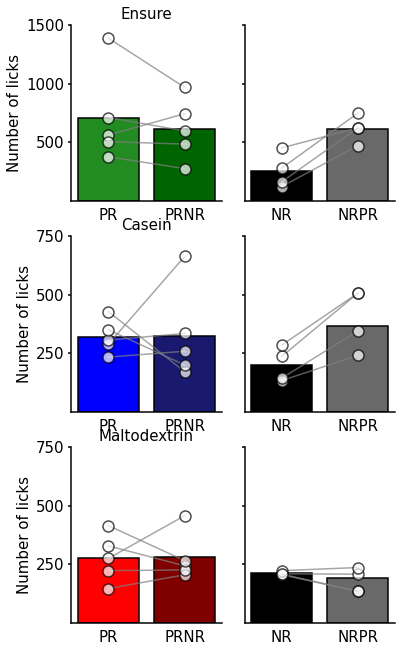

In [160]:
PR_E=['forestgreen','darkgreen']
PR_C=['b','midnightblue']
PR_M=['r','maroon']
NR=['black','dimgray']

f,ax=plt.subplots(figsize=(6,10), ncols=2, nrows=3, sharey='row')
f.subplots_adjust(wspace=0.15, bottom=0.05, left=0.15)

#Ensure
tp.barscatter([ensure_PR,ensure_PRNR], 
              paired= True,
              barfacecolor=PR_E,
              barlabels=['PR','PRNR'],
              barlabeloffset=0.04,
              barfacecolor_option='individual',
              fontsize = 15,
              scattersize=110,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[0,0])

tp.barscatter([ensure_NR,ensure_NRPR], 
              paired= True,
              barfacecolor=NR,
              barlabels=['NR','NRPR'],
              barlabeloffset=0.04,
              barfacecolor_option="individual",
              fontsize = 15,
              scattersize=110,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[0,1])
#casein

tp.barscatter([cas_PR,cas_PRNR], 
              paired= True,
              barfacecolor=PR_C,
              barlabels=['PR','PRNR'],
              barlabeloffset=0.04,
              barfacecolor_option='individual',
              fontsize = 15,
              scattersize=110,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[1,0])

tp.barscatter([cas_NR,cas_NRPR], 
              paired= True,
              barfacecolor=NR,
              barlabels=['NR','NRPR'],
              barlabeloffset=0.04,
              barfacecolor_option="individual",
              fontsize = 15,
              scattersize=110,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[1,1])

#maltodextrin

tp.barscatter([malt_PR,malt_PRNR], 
              paired= True,
              barfacecolor=PR_M,
              barlabels=['PR','PRNR'],
              barlabeloffset=0.04,
              barfacecolor_option='individual',
              fontsize = 15,
              scattersize=110,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[2,0])

tp.barscatter([malt_NR,malt_NRPR], 
              paired= True,
              barfacecolor=NR,
              barlabels=['NR','NRPR'],
              barlabeloffset=0.04,
              barfacecolor_option="individual",
              fontsize = 15,
              scattersize=110,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[2,1])



ax[0,0].set_ylabel('Number of licks',fontsize = 15)
ax[0,0].set_yticks([500,1000,1500])
ax[0,1].set_yticks([500,1000,1500])
ax[0,0].set_yticklabels([500,1000,1500], fontsize = 15)

ax[1,0].set_ylabel('Number of licks',fontsize = 15)
ax[1,0].set_yticks([250,500,750])
ax[1,1].set_yticks([250,500,750])
ax[1,0].set_yticklabels([250,500,750], fontsize = 15)

ax[2,0].set_ylabel('Number of licks',fontsize = 15)
ax[2,0].set_yticks([250,500,750])
ax[2,1].set_yticks([250,500,750])
ax[2,0].set_yticklabels([250,500,750], fontsize = 15)

ax[0,0].set_title('Ensure', fontsize =15)
ax[1,0].set_title('Casein', fontsize =15)
ax[2,0].set_title('Maltodextrin', fontsize =15)

In [61]:
tp.barscatter?

Signature:
tp.barscatter(
    data_in,
    ax=[],
    transpose=False,
    paired=False,
    spaced=False,
    xspace=0.1,
    yspace=20,
    groupwidth=0.75,
    barwidth=0.8,
    barfacecolor_option='same',
    barfacecolor=['white'],
    baredgecolor_option='same',
    baredgecolor=['black'],
    errorbars=False,
    scatteroffset=0,
    scatterfacecolor_option='same',
    scatterfacecolor=['white'],
    scatteredgecolor_option='same',
    scatteredgecolor=['black'],
    scatterlinecolor='grey',
    linewidth=0.75,
    scattersize=80,
    grouplabel=[],
    grouplabeloffset=0,
    barlabels=[],
    barlabeloffset=0.025,
    itemlabels=[],
    show_legend=False,
    legendloc='upper right',
    fontsize=10,
    bar_kwargs={},
    sc_kwargs={'alpha': 0.7, 'linewidth': 1.5, 'zorder': 20, 'clip_on': False},
    ax_kwargs={},
    **extra_kwargs,
)
Docstring: <no docstring>
File:      c:\users\mko102\anaconda3\lib\site-packages\trompy\barscatter.py
Type:      function


In [115]:
AxesSubplot?

Object `AxesSubplot` not found.
